In [5]:
# Import necessary packages
import pandas as pd 
import os
from helper_functions import date_to_decimal_year, rain_predictor, data_cleaner, data_expand
from plot_functions import eruption_counter, annual_plotter, bar_plotter, by_strength
from el_nino_functions import elnino_strengths, nino_dict
import numpy as np

In [2]:
# Create path to data
folder_env_variable = 'MY_FOLDER_PATH'
default_folder_path = '/Users/jonathanquartin/Documents/Coding/GitHub/precip-notebooks/GALAPAGOS_DATA'

folder_path = os.environ.get(folder_env_variable, default_folder_path)

In [3]:
# Import tables
volcanic_events = pd.read_csv(os.path.join(folder_path, "erupt_2024.csv"))
rainfall = pd.read_csv(os.path.join(folder_path, "update_2024.csv"))

bellavista = pd.read_csv(os.path.join(folder_path, "climate_bellavista.csv"))
ayora = pd.read_csv(os.path.join(folder_path, "climate_puerto-ayora.csv"))

oni = pd.read_csv(os.path.join(folder_path, "oni.csv"))

Eruption data must have columns: 'Volcano' and 'Start'. 'Start' is the beginning date of the eruption given as a string-- YYYY-MM-DD.

Rainfall data must have columns: 'Date', 'Longitude', 'Latitude', and 'Precipitation'. 'Date' is given as a string YYYY-MM-DD and the other three columns are floats.

In [6]:
sites_dict = {'Wolf': (-91.35, .05, 'Wolf'), 'Fernandina': (-91.55, -.35, 'Fernandina'), 'Negra, Sierra': (-91.15, -.85, 'Sierra Negra'), 'Azul, Cerro': (-91.35, -.95, 'Cerro Azul')} # Long/lat pairs must exist in rainfall data
quantiles = 3 # Number of bins to break up rainfall into
rolling_number = 90 # Number of days to average rainfall over
log_flag = True # If true, applies a log scaling to the data
by_season = False # Make true if you want to consider rainfall quantiles yearly, or False to consider rainfall quantiles across the entire date range

# Uncomment below to use rain predictor gauge location. (For analyses of eruptions between 1964 and 2000)
# start = rainfall['Date'].min()
# compare_site = ayora
# rain_gauge = data_cleaner(compare_site)
# rainfall = data_expand(rain_gauge[rain_gauge['Date'] < start], [[sites_dict[i][0], sites_dict[i][1]] for i in sites_dict])

elninos = nino_dict(oni, rainfall)



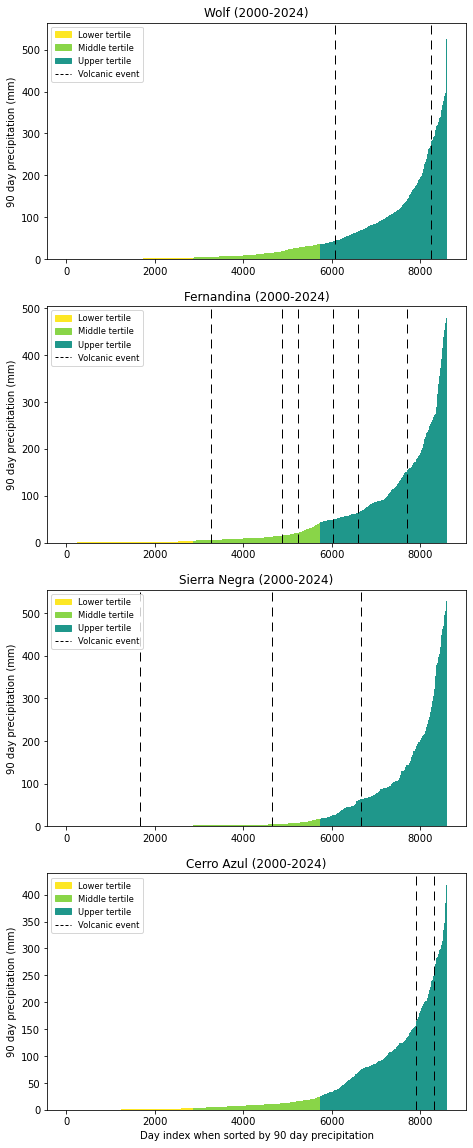

In [7]:
all_rain, event_rain = by_strength(sites_dict, volcanic_events, rainfall, quantiles, rolling_number, False, elninos=None, recur=False)